# Multi-label Pascal VOC 2007 CAM Assisted Training

**References**

- Zhou, Bolei, Aditya Khosla, Agata Lapedriza, Aude Oliva, and Antonio Torralba. “Learning deep features for discriminative localization.” IEEE conference on computer vision and pattern recognition (CVPR), pp. 2921-2929. 2016. [1512.04150](https://arxiv.org/pdf/1512.04150.pdf)

In [1]:
#@title

! pip -qq install tensorflow-addons

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 706kB 7.3MB/s 
Mounted at /content/drive


In [2]:
import tensorflow as tf

class Config:
  class data:
    size = (512, 512)
    shape = (*size, 3)
    batch_size = 32
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 120391
    shuffle = True

    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value((x+1)*127.5, 0, 255), tf.uint8)

  class aug:
    brightness_delta =  .2
    saturation_lower =  .2
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0
    
  class model:
    last_spatial_layer = 'resnet101v2'
    first_dense_layer = 'avg_pool'
    backbone = tf.keras.applications.ResNet101V2
  
  class training:
    epochs = 80
    learning_rate = .002
    lr_first_decay_steps = 50
    
    fine_tune_lr = .00001
    fine_tune_epochs = 20
    fine_tune_layers = .6  # 60%
    freeze_batch_norm = False

    fine_tune_early_stopping_patience = 20
  
  class explaining:
    noise = tf.constant(.2)
    repetitions = tf.constant(8)

    score_activations = tf.constant(256)
  
  class segmentation:
    class data:
      batch_size = 16
      shuffle_buffer_size = 8 * batch_size

    class training:
      epochs = 100
      early_stopping_patience = epochs // 3
      reduce_lr_on_plateau_patience = max(5, epochs // 10)

      # Loss params
      cl_ce_w = 0.05
      lr_initial = .005
      lr_first_decay_steps = 10  # None for constant learning-rate


  class experiment:
    seed = 218402
    override = True
    logs                 = '/content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout/'
    fine_tune_logs       = '/content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout-fine-tune/'
    segmentation_logs    = '/content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout-segmentation/'

    training_weights     = '/content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout/weights.h5'
    fine_tune_weights    = '/content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout-fine-tune/weights.h5'
    segmentation_weights = '/content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout-segmentation/weights.h5'

## Setup

In [3]:
import os
import shutil
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [4]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.
Physical devices cannot be modified after being initialized


In [5]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [6]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [7]:
# We define cosine decay restarts here because it's only available
# in tensorflow nightly build at this time.
#
class CosineDecayRestarts(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(
      self,
      initial_learning_rate,
      first_decay_steps,
      t_mul=2.0,
      m_mul=1.0,
      alpha=1e-6,
      name=None):
    super(CosineDecayRestarts, self).__init__()

    self.initial_learning_rate = initial_learning_rate
    self.first_decay_steps = first_decay_steps
    self._t_mul = t_mul
    self._m_mul = m_mul
    self.alpha = alpha
    self.name = name

  def __call__(self, step):
    with tf.name_scope(self.name or "SGDRDecay") as name:
      initial_learning_rate = tf.convert_to_tensor(self.initial_learning_rate, name="initial_learning_rate")
      dtype = initial_learning_rate.dtype
      first_decay_steps = tf.cast(self.first_decay_steps, dtype)
      alpha = tf.cast(self.alpha, dtype)
      t_mul = tf.cast(self._t_mul, dtype)
      m_mul = tf.cast(self._m_mul, dtype)

      global_step_recomp = tf.cast(step, dtype)
      completed_fraction = global_step_recomp / first_decay_steps

      def compute_step(completed_fraction, geometric=False):
        """Helper for `cond` operation."""
        if geometric:
          i_restart = tf.math.floor(
              tf.math.log(1.0 - completed_fraction * (1.0 - t_mul)) /
              tf.math.log(t_mul))

          sum_r = (1.0 - t_mul**i_restart) / (1.0 - t_mul)
          completed_fraction = (completed_fraction - sum_r) / t_mul**i_restart

        else:
          i_restart = tf.math.floor(completed_fraction)
          completed_fraction -= i_restart

        return i_restart, completed_fraction

      i_restart, completed_fraction = tf.cond(
          tf.math.equal(t_mul, 1.0),
          lambda: compute_step(completed_fraction, geometric=False),
          lambda: compute_step(completed_fraction, geometric=True))

      m_fac = m_mul**i_restart
      cosine_decayed = 0.5 * m_fac * (1.0 + tf.math.cos(
          tf.constant(math.pi) * completed_fraction))
      decayed = (1 - alpha) * cosine_decayed + alpha

      return tf.math.multiply(initial_learning_rate, decayed, name=name)

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "first_decay_steps": self.first_decay_steps,
        "t_mul": self._t_mul,
        "m_mul": self._m_mul,
        "alpha": self.alpha,
        "name": self.name
    }

## Dataset

### Augmentation Policy

In [8]:
def default_policy_fn(image):
  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # image = tf.image.stateless_random_crop(image, [*Config.data.size, 3], seed=seeds[:, 0])
  # mask = tf.image.stateless_random_crop(mask, [*Config.data.size, 1], seed=seeds[:, 0])

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  # mask = tf.image.stateless_random_flip_left_right(mask, seed=seeds[:, 0])
  
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  # mask = tf.image.stateless_random_flip_up_down(mask, seed=seeds[:, 1])

  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

### Preparing and Performance Settings

In [9]:
%%bash

if ! [ -d "/root/tensorflow_datasets/voc/2007" ]; then
  unzip -nq "/content/drive/MyDrive/unicamp_datasets/pascal-voc-2007.zip" -d /
else
  echo "Data found at voc/2007 - skipping"
fi

In [10]:
(train_dataset, val_dataset, test_dataset), info = tfds.load(
  'voc/2007',
  split=('train', 'validation', 'test'),
  with_info=True,
  shuffle_files=False
)

In [11]:
CLASSES = np.asarray(info.features['objects']['label']._int2str)
int2str = info.features['objects']['label'].int2str

In [12]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['objects']['label']

  image = tf.cast(image, tf.float32)
  
  image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=True)
            .prefetch(Config.data.prefetch_buffer_size))

In [13]:
train = prepare(train_dataset, Config.data.batch_size, shuffle=True, augment=True)
valid = prepare(val_dataset, Config.data.batch_size)
test = prepare(test_dataset, Config.data.batch_size)

### Examples in The Dataset

In [14]:
def talk_about(dataset, batches, tag):
  print(tag)
  print(f'  {batches}')
  print(f'  samples: {len(dataset)}')
  print(f'  steps  : {len(batches)}')
  print()


talk_about(train_dataset, train, 'Training')
talk_about(val_dataset, valid, 'Validation')

Training
  <PrefetchDataset shapes: ((32, 512, 512, 3), (32, 20)), types: (tf.float32, tf.float32)>
  samples: 2501
  steps  : 78

Validation
  <PrefetchDataset shapes: ((32, 512, 512, 3), (32, 20)), types: (tf.float32, tf.float32)>
  samples: 2510
  steps  : 78



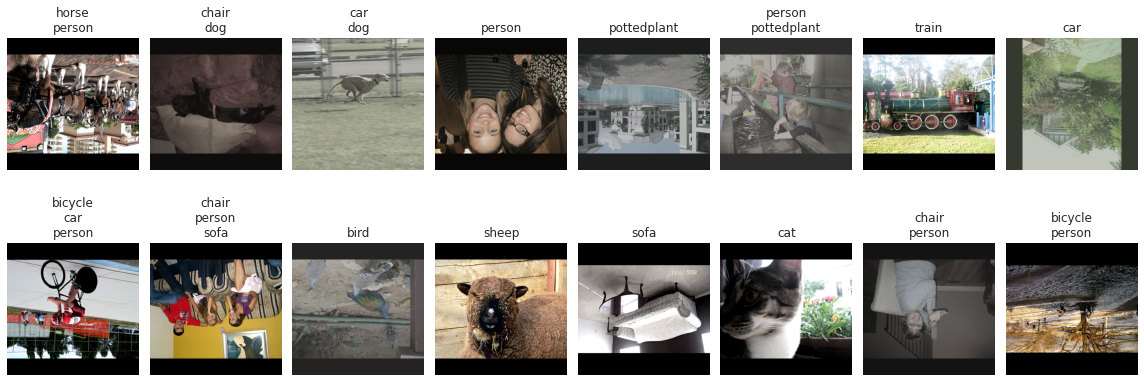

In [15]:
#@title

for images, labels in train.take(1):
  gt = ['\n'.join(CLASSES[l].astype(str))
        for l in labels.numpy().astype(bool)]

  visualize(
    Config.data.deprocess(images[:16]),
    gt,
    rows=2,
    figsize=(16, 6)
  )

## Network

In [16]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  classifier_activation=None,
  include_top=False,
  input_shape=Config.data.shape
)

Loading ResNet101V2
171319296/171317808 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.python.keras.layers.ops import core as core_ops
from tensorflow.keras.layers import Conv2D, Dense, Dropout


class DenseKur(Dense):
  """Dense with Softmax Weights.
  """
  def call(self, inputs):
    kernel = self.kernel
    ag = tf.abs(kernel)
    ag = ag - tf.reduce_max(ag, axis=-1, keepdims=True)
    ag = tf.nn.softmax(ag)

    return core_ops.dense(
        inputs,
        ag * kernel,
        self.bias,
        self.activation,
        dtype=self._compute_dtype_object)

In [17]:
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D


def build_specific_classifier(
    backbone,
    classes,
    dropout_rate=0.5,
    name=None,
    gpl='avg_pool',
):
  x = backbone.input
  y = backbone.output
  y = GlobalAveragePooling2D(name='avg_pool')(y)
  y = Dropout(rate=dropout_rate, name='top_dropout')(y)
  # y = DenseKur(classes, name='predictions')(y)
  y = Dense(classes, name='predictions')(y)

  return tf.keras.Model(
    x,
    y,
    name=name
  )

backbone.trainable = False

nn = build_specific_classifier(backbone, len(CLASSES), name='resnet101v2_voc_20')

## Training

### Loss, Metrics and Model Compilation

In [20]:
class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class AUC(FromLogitsMixin, tf.metrics.AUC):
  ...

class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

In [21]:
model_metrics = [
  AUC(from_logits=True),
  BinaryAccuracy(from_logits=True),
  F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
  Precision(from_logits=True),
  Recall(from_logits=True),
  # TruePositives(from_logits=True),
  # FalsePositives(from_logits=True),
  # TrueNegatives(from_logits=True),
  # FalseNegatives(from_logits=True),
]

In [22]:
nn.compile(
    optimizer=tf.optimizers.SGD(learning_rate=Config.training.learning_rate, momentum=0.9, nesterov=True),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=model_metrics)

In [23]:
nn.evaluate(tf.random.normal((2, *Config.data.shape)));

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - auc: 0.0000e+00 - binary_accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


### Top Classifier Training

In [ ]:
cs = [
    callbacks.TerminateOnNaN(),
    callbacks.ModelCheckpoint(Config.experiment.training_weights,
                              save_best_only=True,
                              save_weights_only=True,
                              verbose=1),
    callbacks.TensorBoard(
      Config.experiment.logs,
      write_graph=True,
      profile_batch=0)
]

In [ ]:
try:
  if os.path.exists(Config.experiment.logs):
    if not Config.experiment.override:
      raise ValueError(f'A training was found in {Config.experiment.logs}. '
                       f'Either move it or set experiment.override to True.')

    print(f'Overriding previous training at {Config.experiment.logs}.')
    shutil.rmtree(Config.experiment.logs)

  nn.fit(
    train,
    validation_data=valid,
    epochs=Config.training.epochs,
    callbacks=cs
  );

except KeyboardInterrupt: print('\ninterrupted')
else: print('\ndone')

Epoch 1/80
78/78 [==============================] - 182s 2s/step - loss: 0.2395 - auc: 0.8069 - binary_accuracy: 0.9254 - f1_score: 0.2465 - precision: 0.5616 - recall: 0.3273 - val_loss: 0.1287 - val_auc: 0.9535 - val_binary_accuracy: 0.9590 - val_f1_score: 0.5467 - val_precision: 0.8480 - val_recall: 0.5754

Epoch 00001: val_loss improved from inf to 0.12872, saving model to /content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout/weights.h5
Epoch 2/80
78/78 [==============================] - 142s 2s/step - loss: 0.1388 - auc: 0.9356 - binary_accuracy: 0.9506 - f1_score: 0.4842 - precision: 0.7826 - recall: 0.5334 - val_loss: 0.0999 - val_auc: 0.9681 - val_binary_accuracy: 0.9676 - val_f1_score: 0.6615 - val_precision: 0.9002 - val_recall: 0.6559

Epoch 00002: val_loss improved from 0.12872 to 0.09987, saving model to /content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout/weights.h5
Epoch 3/80
78/78 [==============================] - 142s 2s/step - loss: 0.1207 - auc:

### Fine-Tuning

In [24]:
nn.load_weights(Config.experiment.logs + '/weights.h5')

In [28]:
trained_epochs = 80  # len(nn.history.history['loss'])

In [29]:
cs = [
    callbacks.TerminateOnNaN(),
    callbacks.ModelCheckpoint(Config.experiment.fine_tune_weights,
                              save_best_only=True,
                              save_weights_only=True,
                              verbose=1),
    callbacks.EarlyStopping(patience=Config.training.fine_tune_early_stopping_patience, verbose=1),
    callbacks.TensorBoard(
      Config.experiment.fine_tune_logs,
      write_graph=False)
]

In [30]:
if Config.training.fine_tune_epochs:
  backbone.trainable = True

  frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))
  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.training.freeze_batch_norm))

  nn.compile(
    optimizer=tf.optimizers.SGD(learning_rate=Config.training.fine_tune_lr, momentum=0.9, nesterov=True),
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=model_metrics)

In [31]:
if Config.training.fine_tune_epochs:
  print(f'Fine tuning params:')
  print(f'  epochs:          {Config.training.fine_tune_epochs}')
  print(f'  learning rate:   {Config.training.fine_tune_lr}')
  print(f'  layers unfrozen: {frozen_layer_ix} to {len(backbone.layers)}')

  try:
    history = nn.fit(
      train,
      validation_data=valid,
      epochs=trained_epochs + Config.training.fine_tune_epochs,
      callbacks=cs,
      initial_epoch=trained_epochs,
    );

  except KeyboardInterrupt: print('\ninterrupted')
  else: print('\ndone')

Fine tuning params:
  epochs:          20
  learning rate:   1e-05
  layers unfrozen: 150 to 377
Epoch 81/100
78/78 [==============================] - 240s 3s/step - loss: 0.1075 - auc: 0.9653 - binary_accuracy: 0.9618 - f1_score: 0.5800 - precision: 0.8547 - recall: 0.6179 - val_loss: 0.0764 - val_auc: 0.9817 - val_binary_accuracy: 0.9725 - val_f1_score: 0.7173 - val_precision: 0.8160 - val_recall: 0.8336

Epoch 00081: val_loss improved from inf to 0.07643, saving model to /content/drive/MyDrive/unicamp_logs/pascal/resnet101-ce-dropout-fine-tune/weights.h5
Epoch 82/100
78/78 [==============================] - 204s 3s/step - loss: 0.0801 - auc: 0.9830 - binary_accuracy: 0.9695 - f1_score: 0.6491 - precision: 0.8455 - recall: 0.7489 - val_loss: 0.0695 - val_auc: 0.9816 - val_binary_accuracy: 0.9759 - val_f1_score: 0.7191 - val_precision: 0.8714 - val_recall: 0.8094

Epoch 00082: val_loss improved from 0.07643 to 0.06954, saving model to /content/drive/MyDrive/unicamp_logs/pascal/resnet1

## Evaluation

In [32]:
#@title

def labels_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for images, labels in dataset:
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))

In [33]:
if Config.training.fine_tune_epochs:
  backbone.trainable = True

  frozen_layer_ix = int((1-Config.training.fine_tune_layers) * len(backbone.layers))

  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.training.freeze_batch_norm))

In [34]:
nn.load_weights(Config.experiment.fine_tune_weights)

In [35]:
l, p = labels_and_probs(nn, test)

In [36]:
from sklearn import metrics as skmetrics

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_

  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  skmetrics.accuracy_score(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm

test_report, test_mcm = metrics_per_label(l, p)

In [37]:
test_report.round(4)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.9268,0.9994,0.0006,0.0732,0.9845,0.9268,0.9985,0.9548,0.9378,205,aeroplane
1,0.8138,0.9983,0.0017,0.1862,0.9617,0.8138,0.9829,0.8816,0.8396,247,bicycle
2,0.8785,0.9985,0.0015,0.1215,0.9731,0.8785,0.9866,0.9234,0.8959,288,bird
3,0.8857,0.9973,0.0027,0.1143,0.9226,0.8857,0.9911,0.9038,0.8929,175,boat
4,0.5833,0.9851,0.0149,0.4167,0.6667,0.5833,0.9452,0.6222,0.5983,240,bottle
5,0.7705,0.9941,0.0059,0.2295,0.8343,0.7705,0.9831,0.8011,0.7825,183,bus
6,0.8204,0.9803,0.0197,0.1796,0.8856,0.8204,0.9686,0.8518,0.8327,774,car
7,0.8663,0.9983,0.0017,0.1337,0.9727,0.8663,0.9850,0.9164,0.8856,329,cat
8,0.6514,0.9660,0.0340,0.3486,0.7044,0.6514,0.9458,0.6768,0.6613,545,chair
9,0.7857,0.9942,0.0058,0.2143,0.7795,0.7857,0.9896,0.7826,0.7845,126,cow


In [ ]:
co_occurrence = tf.transpose(l) @ l
occurrence = tf.reshape(np.diag(co_occurrence), (-1, 1))

co_occurrence_rate = tf.math.divide_no_nan(co_occurrence, occurrence)

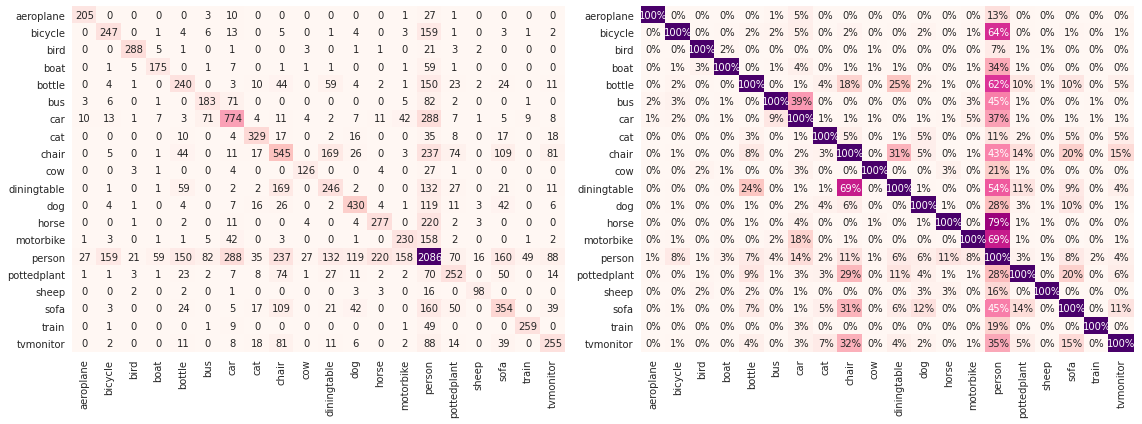

In [ ]:
#@title Labels Occurrence Matrix

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.heatmap(
  co_occurrence.numpy().astype(int),
  annot=True,
  fmt='d',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)

plt.subplot(122)
sns.heatmap(
  co_occurrence_rate.numpy(),
  annot=True,
  fmt='.0%',
  xticklabels=CLASSES,
  yticklabels=CLASSES,
  cmap="RdPu",
  cbar=False
)
plt.tight_layout();